In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

img_transform = transforms.Compose(
            [transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(),
            normalize])

trainset = torchvision.datasets.CIFAR10(root='./datas3', train=True,
                                        download=True, transform=img_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./datas3', train=False,
                                       download=True, transform=img_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./datas3/cifar-10-python.tar.gz to ./datas3
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


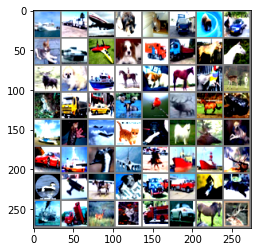

 ship truck plane   dog


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
resnet_model = torchvision.models.resnet18(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
import torch.nn.functional as F

class ResNet18(torch.nn.Module):
    def __init__(self, original_model, last_layer_num):
        super(ResNet18, self).__init__()
        self.features = torch.nn.Sequential(*list(original_model.children())[:-last_layer_num])
        self.fc = torch.nn.Linear(in_features = 512, out_features=10, bias=True)
        print("AAA",self.features)
        
    def forward(self, x):
        x = self.features(x)
        x = F.normalize(x, p=2, dim=1)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

In [7]:
new_resnet18 = ResNet18(resnet_model, 1).cuda()

AAA Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2):

In [0]:
import torch.optim as optim
import torch.nn as nn
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(new_resnet18.parameters(), lr=1e-2, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
import time
import copy
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    epoch_losses, epoch_accus = [], []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase


        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

            # Iterate over data.
        for i, data in enumerate(trainloader, 0):
            #print(i)
            inputs, labels = data
            #print(inputs.shape)
            inputs = inputs.cuda()
            labels = labels.cuda()
            #print(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs).squeeze()
                #print(outputs)
                _, preds = torch.max(outputs, 1)
                #preds = preds + 1
                #print(labels)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                
                loss.backward()
                optimizer.step()

            # statistics

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            #print(preds, labels.data)

        scheduler.step()

        epoch_loss = running_loss / len(trainloader.dataset)
        epoch_losses.append(epoch_loss)
        epoch_acc = running_corrects.double() / len(trainloader.dataset)
        epoch_accus.append(epoch_acc)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            'train', epoch_loss, epoch_acc))

        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_losses, epoch_accus

In [10]:
resnet_trained, epoch_losses, epoch_accus = train_model(new_resnet18, criterion, optimizer, lr_scheduler, num_epochs = 30)

Epoch 0/29
----------
train Loss: 1.6312 Acc: 0.5887

Epoch 1/29
----------
train Loss: 0.8883 Acc: 0.7589

Epoch 2/29
----------
train Loss: 0.6750 Acc: 0.8024

Epoch 3/29
----------
train Loss: 0.5631 Acc: 0.8283

Epoch 4/29
----------
train Loss: 0.4891 Acc: 0.8487

Epoch 5/29
----------
train Loss: 0.4300 Acc: 0.8659

Epoch 6/29
----------
train Loss: 0.3818 Acc: 0.8802

Epoch 7/29
----------
train Loss: 0.2703 Acc: 0.9232

Epoch 8/29
----------
train Loss: 0.2316 Acc: 0.9359

Epoch 9/29
----------
train Loss: 0.2132 Acc: 0.9424

Epoch 10/29
----------
train Loss: 0.1949 Acc: 0.9494

Epoch 11/29
----------
train Loss: 0.1812 Acc: 0.9533

Epoch 12/29
----------
train Loss: 0.1670 Acc: 0.9590

Epoch 13/29
----------
train Loss: 0.1573 Acc: 0.9618

Epoch 14/29
----------
train Loss: 0.1465 Acc: 0.9658

Epoch 15/29
----------
train Loss: 0.1440 Acc: 0.9664

Epoch 16/29
----------
train Loss: 0.1425 Acc: 0.9671

Epoch 17/29
----------
train Loss: 0.1395 Acc: 0.9685

Epoch 18/29
--------

In [11]:
from google.colab import files 
torch.save(new_resnet18, './resnet18_64r2.pth')
files.download('./resnet18_64r2.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ResNet18. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


NameError: ignored

In [14]:
hit, count = 0, 0
resnet_trained.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels. cuda()
        outputs = resnet_trained(images)
        _, pred = torch.max(outputs.data, 1)
        #print(pred)
        count += labels.size(0)
        hit += (pred == labels).sum().item()

print(hit / count)

0.8603
0.8622


In [0]:
model = resnet_trained.cuda()

In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane : 91 %
Accuracy of   car : 90 %
Accuracy of  bird : 79 %
Accuracy of   cat : 68 %
Accuracy of  deer : 89 %
Accuracy of   dog : 84 %
Accuracy of  frog : 92 %
Accuracy of horse : 90 %
Accuracy of  ship : 93 %
Accuracy of truck : 89 %


In [0]:
def create_confusion_matrix(predict, validate, class_to_index):
    nclass = len(np.unique(predict))
    cm = np.zeros(shape=(nclass,nclass))
    for i, val in enumerate(predict):
        row = class_to_index[validate[i]]
        col = class_to_index[predict[i]]
        cm[row, col] += 1
    return cm.astype(int)

def plot_confusion_matrix(predict, validate, title, ax, class_to_index, index_to_class):
    cm = create_confusion_matrix(predict, validate, class_to_index)
    nclass = len(np.unique(predict))
    ax.imshow(cm, cmap='Blues')
    ax.set_ylabel('Ground Truth')
    ax.set_xlabel('Prediction')
    ax.set_xticks(np.arange(nclass), )
    ax.set_yticks(np.arange(nclass))
    ax.set_xticklabels([index_to_class[i] for i in range(nclass)], rotation = 45, ha="right")
    ax.set_yticklabels([index_to_class[i] for i in range(nclass)])
    ax.set_xticks([-0.5, -0.5+nclass], minor=True)
    ax.set_yticks([-0.5, -0.5+nclass], minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_title(title)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [0]:
def plot_loss_and_accuracy(acc, loss, model_name, dataset_name):
    def plot_cross_entropy_loss(loss, ax):
        training_loss = ax.plot( loss, label='training loss')
        ax.legend()
        ax.set_title('Loss of {} on {}'.format(model_name, dataset_name))
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
                     
        return ax
    
    def plot_mpc_accuracy(acc, ax):
        ax.plot(acc, label='training accuracy')
        ax.legend()
        ax.set_title('Accuracy of {} on {}'.format(model_name, dataset_name))
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')
        return ax
    
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0] = plot_cross_entropy_loss(loss, ax[0])
    ax[1] = plot_mpc_accuracy(acc, ax[1])

In [0]:
predicted = []
ground_truth = []
for data in testloader:
    images, labels = data
    outputs = model(images.cuda())
    _, tmp = torch.max(outputs, 1)
    predicted += list(tmp.detach().cpu().numpy())
    ground_truth += list(labels.detach().cpu().numpy())

In [0]:
class_to_index = {i:i for i in range(10)}
index_to_class = {i:i for i in range(10)}

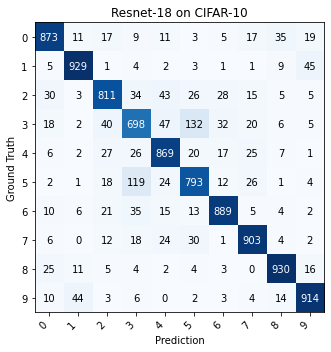

In [23]:
from google.colab import files 
fig, ax = plt.subplots(figsize=(5,5))
ax = plot_confusion_matrix(predicted, ground_truth, 'Resnet-18 on CIFAR-10', ax, class_to_index, index_to_class)
plt.savefig('Resnet18_Cifar_CM.png')
files.download('Resnet18_Cifar_CM.png')

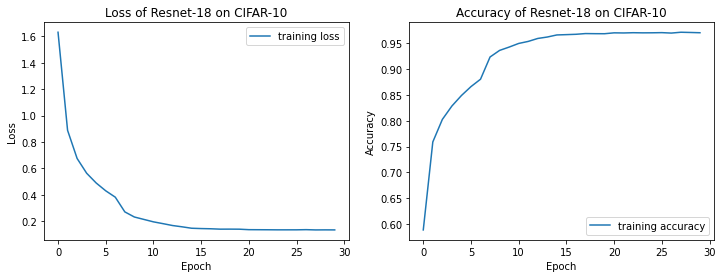

In [24]:
plot_loss_and_accuracy(epoch_accus, epoch_losses, 'Resnet-18', 'CIFAR-10')
plt.savefig("Resnet18_Cifar_accu_loss.png")
files.download("Resnet18_Cifar_accu_loss.png")